# Chapter 18 – Reinforcement Learning
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alirezatheh/handson-ml3-notes/blob/main/notebooks/18_reinforcement_learning.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/alirezatheh/handson-ml3-notes/blob/main/notebooks/18_reinforcement_learning.ipynb)

A revolution took place in 2013, when researchers from a British startup called DeepMind Volodymyr Mnih et al. demonstrated a system that could learn to play just about any Atari game from scratch in a paper [“Playing Atari with Deep Reinforcement Learning”](https://homl.info/dqn), eventually outperforming humans in most of them in a 2015 paper [“Human-Level Control Through Deep Reinforcement Learning”](https://homl.info/dqn2), using only raw pixels as inputs and without any prior knowledge of the rules of the games.

## Learning to Optimize Rewards
In reinforcement learning, a software *agent* makes observations and takes actions within an *environment*, and in return it receives *rewards* from the environment. Its objective is to learn to act in a way that will maximize its expected rewards over time.

Here are a few examples:
- **a.** The agent can be the program controlling a robot. In this case, the environment is the real world, the agent observes the environment through a set of sensors such as cameras and touch sensors, and its actions consist of sending signals to activate motors. It may be programmed to get positive rewards whenever it approaches the target destination, and negative rewards whenever it wastes time or goes in the wrong direction.
- **b.** The agent can be the program controlling *Ms. Pac-Man*. In this case, the environment is a simulation of the Atari game, the actions are the nine possible joystick positions (upper left, down, center, and so on), the observations are screenshots, and the rewards are just the game points.
- **c.** The agent can be the program playing a board game such as Go. It only gets a reward if it wins.
- **d.** The agent does not have to control a physically (or virtually) moving thing. e.g. it can be a smart thermostat, getting positive rewards whenever it is close to the target temperature and saves energy, and negative rewards when humans need to tweak the temperature, so the agent must learn to anticipate human needs.
- **e.** The agent can observe stock market prices and decide how much to buy or sell every second. Rewards are obviously the monetary gains and losses.

Note that there may not be any positive rewards at all; e.g., the agent may move around in a maze, getting a negative reward at every time step, so it had better find the exit as quickly as possible! There are other tasks such as self-driving cars, recommender systems, placing ads on a web page, or controlling where an image classification system should focus its attention.

## Policy Search
The algorithm a software agent uses to determine its actions is called its *policy*. It could be a neural network taking observations as inputs and outputting the action to take. It can be any algorithm, and it does not have to be deterministic. If a policy involves some randomness, it is called a *stochastic policy*. One possible learning algorithm could be to try out many different values for parameters, and pick the combination that performs best. This is an example of *policy search*, in this case using a brute-force approach. 

Another way is to use *genetic algorithms*. We could randomly create a first generation of 100 policies and try them out, then “kill” the 80 worst policies and make the 20 survivors produce 4 offspring each. An offspring is a copy of its parent(s) plus some random variation. The surviving policies plus their offspring together constitute the second generation. We can continue to iterate through generations this way until we find a good policy.

Another approach is to use optimization techniques, by evaluating the gradients of the rewards with regard to the policy parameters, then tweaking these parameters by following the gradients toward higher rewards. This is called *policy gradients* (PG).

## Introduction to ~~OpenAI Gym~~ Gymnasium
We generally need a *simulated environment* at least for bootstrap training. We might use a library like [PyBullet](https://pybullet.org) or [MuJoCo](https://mujoco.org) for 3D physics simulation. 

In this notebook we will be using [Gymnasium](https://github.com/Farama-Foundation/Gymnasium), a great toolkit for developing and comparing RL algorithms. It provides many environments for our learning agents to interact with.

Let’s install the Gymnasium library. We’ll also install the extra libraries needed for classic *control theory* environments (including CartPole, which we will use shortly), as well as for Box2D and Atari environments, which are needed for the exercises.

**Important notes**:
- OpenAI has handed over the maintenance and developmnent of the Gym library to the Farama foundation (see the [announcement](https://farama.org/Announcing-The-Farama-Foundation)), and the library was renamed to Gymnasium. It’s a drop-in replacement for OpenAI Gym: we can just install `gymnasium` instead of `gym`, and `import gymnasium as gym`, and everything should work fine.
- by running the following cell, we accept the Atari ROM license.

In [1]:
import sys

if 'google.colab' in sys.modules or 'kaggle_secrets' in sys.modules:
    %pip install -q -U swig
    %pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]

**Warning**: This chapter can be very slow without a GPU, so let’s make sure 
there’s one, or else issue a warning:

In [2]:
import tensorflow as tf

if not tf.config.list_physical_devices('GPU'):
    print('No GPU was detected. Neural nets can be very slow without a GPU.')
    if 'google.colab' in sys.modules:
        print(
            'Go to Runtime > Change runtime and select a GPU hardware '
            'accelerator.'
        )
    if 'kaggle_secrets' in sys.modules:
        print('Go to Settings > Accelerator and select GPU.')

Let’s import Gym and make a new CartPole environment:

In [3]:
import gymnasium as gym

env = gym.make('CartPole-v1', render_mode='rgb_array')

The CartPole (version 1) is a very simple environment composed of a cart that can move left or right, and a pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

<center>
  <img 
    src="../images/18/cartpole_env.png" 
    onerror="
      this.onerror = null;
      const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
      this.src = repo + this.src.split('..')[1];
    "
  >
</center>

**Tip**: `gym.envs.registry` is a dictionary containing all available environments:

In [4]:
# Shows the first few environments
envs = gym.envs.registry
sorted(envs.keys())[:5] + ['...']

['ALE/Adventure-ram-v5',
 'ALE/Adventure-v5',
 'ALE/AirRaid-ram-v5',
 'ALE/AirRaid-v5',
 'ALE/Alien-ram-v5',
 '...']

The registry values are environment specifications:

In [5]:
envs['CartPole-v1']

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

Let’s initialize the environment by calling its `reset()` method. This returns an observation, as well as a dictionary that may contain extra information. Both are environment-specific.

In [6]:
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [7]:
info

{}

In the case of the CartPole, each observation is a 1D NumPy array composed of 4 floats: they represent the cart’s horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity.

An environment can be visualized by calling its `render()` method. If we set `render_mode` to `'rgb_array'` when creating the environment, then this will return a NumPy array.

In [8]:
img = env.render()
# Height, width, channels (3 = Red, Green, Blue)
img.shape

(400, 600, 3)

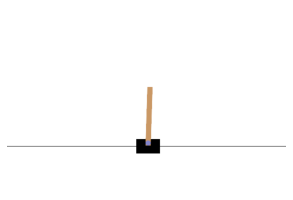

In [9]:
# Creates a little function to render and plot an environment
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')


def plot_environment(
    env: gym.Env, figsize: tuple[int, ...] = (5, 4)
) -> np.ndarray:
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis('off')
    return img


plot_environment(env)
plt.show()

Let’s see how to interact with an environment. Our agent will need to select an action from an *action space* (the set of possible actions). Let’s see what this environment’s action space looks like:

In [10]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left (0) or towards the right (1).

Since the pole is leaning toward the right (`obs[2] > 0`), let’s accelerate the cart toward the right:

In [11]:
# Accelerate right
action = 1
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

Notice that the cart is now moving toward the right (`obs[1] > 0`). The pole is still tilted toward the right (`obs[2] > 0`), but its angular velocity is now negative (`obs[3] < 0`), so it will likely be tilted toward the left after the next step.

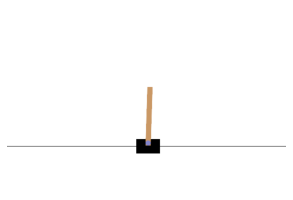

In [12]:
plot_environment(env)
plt.show()

Looks like it’s doing what we’re telling it to do!

The environment also tells the agent how much reward it got during the last step, in this environment, we get a reward of 1.0 at every step, no matter what we do, so the goal is to keep the episode running for as long as possible:

In [13]:
reward

1.0

When the game is over, the environment returns `done=True`. In this case, it’s 
not over yet:

In [14]:
done

False

Some environment wrappers may want to interrupt the environment early. e.g. when a time limit is reached or when an object goes out of bounds. In this case, `truncated` will be set to `True`. In this case, it’s not truncated yet:

In [15]:
truncated

False

Finally, `info` is an environment-specific dictionary that can provide some extra information that we may find useful for debugging or for training. e.g. in some games it may indicate how many lives the agent has.

In [16]:
info

{}

The sequence of steps between the moment the environment is reset until it is done or truncated is called an *episode*. In this case each episode has 200 steps. At the end of an episode (i.e., when `step()` returns `done=True` or `truncated=True`), we should reset the environment before we continue to use it.

In [17]:
if done or truncated:
    obs, info = env.reset()

**Tip**: Once we have finished using an environment, we should call its `close()` method to free resources.

Now how can we make the poll remain upright? We will need to define a *policy*. Let’s hard code a simple policy: if the pole is tilting to the left, then push the cart to the left, and *vice versa*. Let’s see if that works:

In [18]:
def basic_policy(obs: np.ndarray) -> int:
    angle = obs[2]
    return 0 if angle < 0 else 1


totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)

In [19]:
np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

Well, as expected, this strategy is a bit too basic: the best it did was to keep the poll up for only 63 steps. This environment is considered solved when the agent keeps the poll up for 200 steps.

Let’s visualize one episode:

**Tip**: We can learn more about Matplotlib animations in the [Matplotlib tutorial notebook](https://github.com/ageron/handson-ml3/blob/main/tools_matplotlib.ipynb#animations).

In [20]:
# This cell displays an animation of one episode
from typing import Callable

import keras
import matplotlib.animation as animation
from matplotlib.image import AxesImage


def update_scene(
    num: int, frames: list[np.ndarray], patch: AxesImage
) -> tuple[AxesImage]:
    patch.set_data(frames[num])
    return (patch,)


def plot_animation(
    frames: list[np.ndarray], repeat: bool = False, interval: int = 40
) -> animation.FuncAnimation:
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig,
        update_scene,
        fargs=(frames, patch),
        frames=len(frames),
        repeat=repeat,
        interval=interval,
    )
    plt.close()
    return anim


def show_one_episode(
    policy: Callable[[np.ndarray], int], n_max_steps: int = 200, seed: int = 42
) -> animation.FuncAnimation:
    frames = []
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    keras.utils.set_random_seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)


show_one_episode(basic_policy)

Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

## Neural Network Policies
Let’s create a neural network that will take observations as inputs, and output the probabilities of actions to take for each observation. To choose an action, the network will estimate a probability for each action, then we will select an action randomly according to the estimated probabilities. This approach lets the agent find the right balance between *exploring* new actions and *exploiting* the actions that are known to work well. This *exploration/exploitation* dilemma is central in reinforcement learning. In the case of the CartPole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability $p$ of the action 0 (left), and of course the probability of action 1 (right) will be $1-p$.

In [21]:
# Ensures reproducibility on the CPU
keras.utils.set_random_seed(42)

model = keras.Sequential(
    [
        keras.layers.Dense(5, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ]
)

In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment’s full state. If there were some hidden state then we may need to consider past actions and observations in order to try to infer the hidden state of the environment. e.g if the environment only revealed the position of the cart but not its velocity. Or if the observations are noisy: we may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment’s full state.

## Evaluating Actions: The Credit Assignment Problem
To train this neural network we will need to define the target probabilities $\mathbf{y}$. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when we win or lose points in an episode, it is not clear which actions contributed to this result: when the agent gets a reward, it is hard for it to know which actions should get credited (or blamed) for it. This is called the *credit assignment problem*.

A common strategy is to evaluate an action based on the sum of all the rewards that come after it, usually applying a *discount factor*, $\gamma$, at each step. This sum of discounted rewards is called the action’s *return*. If the discount factor is close to 0, then future rewards won’t count for much compared to immediate rewards. Conversely, if the discount factor is close to 1, then rewards far into the future will count almost as much as immediate rewards. Typical discount factors vary from 0.9 to 0.99. In the CartPole environment, actions have fairly short-term effects, so choosing a discount factor of 0.95 seems reasonable.

We want to estimate how much better or worse an action is, compared to the other possible actions, on average. This is called the *action advantage*. For this, we must run many episodes and normalize all the action returns, by subtracting the mean and dividing by the standard deviation. After that, we can reasonably assume that actions with a negative advantage were bad while actions with a positive advantage were good.

## Policy Gradients
One popular class of PG algorithms, called *REINFORCE algorithms*, was introduced in a 1992 paper [“Simple Statistical Gradient-Following Algorithms for Connectionist Reinforcement Leaning”](https://homl.info/132) by Ronald Williams. Here is one common variant:
1. First, let the neural network policy play the game several times, and at each step, compute the gradients that would make the chosen action even more likely (i.e we pretend that whatever action it takes is the right one) but don’t apply these gradients yet.
2. Once we have run several episodes, compute each action’s advantage, using the method described in the previous section.
3. Multiply each gradient vector by the corresponding action’s advantage.
4. Finally, compute the mean of all the resulting gradient vectors, and use it to perform a gradient descent step.

In [22]:
def play_one_step_pg(
    env: gym.Env,
    obs: np.ndarray,
    model: keras.Model,
    loss_fn: keras.losses.Loss,
) -> tuple[np.ndarray, int, bool, bool, tf.Tensor]:
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = tf.random.uniform([1, 1]) > left_proba
        y_target = tf.constant([[1.0]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

If `left_proba` is high, then `action` will most likely be `False` (since a random number uniformally sampled between 0 and 1 will probably not be greater than `left_proba`). And `False` means 0 when we cast it to a number, so `y_target` would be equal to 1 - 0 = 1. In other words, we set the target to 1, meaning we pretend that the probability of going left should have been 100% (so we took the right action).

Now let’s create another function that will rely on the `play_one_step()` function to play multiple episodes, returning all the rewards and gradients, for each episode and each step:

In [23]:
def play_multiple_episodes(
    env: gym.Env,
    n_episodes: int,
    n_max_steps: int,
    model: keras.Model,
    loss_fn: keras.losses.Loss,
) -> tuple[list[list[int]], list[list[tf.Tensor]]]:
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step_pg(
                env, obs, model, loss_fn
            )
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

The PG algorithm uses the model to play the episode several times (e.g., 10 times), then it goes back and looks at all the rewards, discounts them and normalizes them. So let’s create a couple of functions for that: the first will compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [24]:
# Action returns
def discount_rewards(rewards: list[int], discount_factor: float) -> np.ndarray:
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted


# Action advantages
def discount_and_normalize_rewards(
    all_rewards: list[list[int]], discount_factor: float
) -> list[np.ndarray]:
    all_discounted_rewards = [
        discount_rewards(rewards, discount_factor) for rewards in all_rewards
    ]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [
        (discounted_rewards - reward_mean) / reward_std
        for discounted_rewards in all_discounted_rewards
    ]

Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50. If we use a discount factor of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only get -40 (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the first reward (+10), which leads to a discounted reward of -22:

In [25]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

To normalize all discounted rewards across all episodes, we compute the mean and standard deviation of all the discounted rewards, and we subtract the mean from each discounted reward, and divide by the standard deviation:

In [26]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

We are now ready to build and run the training loop:

In [27]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [28]:
# Let’s create the neural net and reset the environment, for
# reproducibility

keras.utils.set_random_seed(42)

model = keras.Sequential(
    [
        keras.layers.Dense(5, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ]
)

obs, info = env.reset(seed=42)

In [29]:
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [30]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn
    )

    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(
        f"\rIteration: {iteration + 1}/{n_iterations},"
        f" mean rewards: {total_rewards / n_episodes_per_update:.1f}",
        end="",
    )

    all_final_rewards = discount_and_normalize_rewards(
        all_rewards, discount_factor
    )
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [
                final_reward * all_grads[episode_index][step][var_index]
                for episode_index, final_rewards in enumerate(
                    all_final_rewards
                )
                for step, final_reward in enumerate(final_rewards)
            ],
            axis=0,
        )
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 150/150, mean rewards: 190.3

Let’s write a small policy function that will use the neural net to choose an action:

In [31]:
def pg_policy(obs: np.arange) -> int:
    left_proba = model.predict(obs[np.newaxis], verbose=0)[0][0]
    return int(np.random.rand() > left_proba)

In [32]:
# Displays the animation
keras.utils.set_random_seed(42)
show_one_episode(pg_policy)

This algorithm solved the CartPole task, but it would not scale well to larger and more complex tasks. Indeed, it is highly *sample inefficient*, meaning it needs to explore the game for a very long time before it can make significant progress. However, it is the foundation of more powerful algorithms, such as *actor-critic* algorithms.

**Tip**: Unless we are writing a paper, we should not hesitate to inject prior knowledge into the agent, as it will speed up training dramatically. e.g. since we know that the pole should be as vertical as possible, we could add negative rewards proportional to the pole’s angle. This will make the rewards much less sparse and speed up training. Also, if we already have a reasonably good policy (e.g., hardcoded), we may want to train the neural network to imitate it before using policy gradients to improve it.

## Markov Decision Processes
In the early 20th century, the mathematician Andrey Markov studied stochastic processes with no memory, called *Markov chains*. Such a process has a fixed number of states, and it randomly evolves from one state to another at each step. The probability for it to evolve from a state $s$ to a state $s^\prime$ is fixed, and it depends only on the pair ($s$, $s^\prime$), not on past states. This is why we say that the system has no memory.

Here is an example:

<center>
  <img 
    src="../images/18/markov_chain.png" 
    onerror="
      this.onerror = null;
      const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
      this.src = repo + this.src.split('..')[1];
    "
  >
</center>

Let’s run this stochastic process a few times to see what it looks like:

In [33]:
keras.utils.set_random_seed(42)

# Shape: [s, s']
transition_probabilities = [
    # From s0 to s0, s1, s2, s3
    [0.7, 0.2, 0.0, 0.1],
    # From s1 to s0, s1, s2, s3
    [0.0, 0.0, 0.9, 0.1],
    # From s2 to s0, s1, s2, s3
    [0.0, 1.0, 0.0, 0.0],
    # From s3 to s0, s1, s2, s3
    [0.0, 0.0, 0.0, 1.0],
]

# To avoid blocking in case of an infinite loop
n_max_steps = 1000
terminal_states = [3]


def run_chain(start_state: int) -> None:
    current_state = start_state
    for step in range(n_max_steps):
        print(current_state, end=' ')
        if current_state in terminal_states:
            break
        current_state = np.random.choice(
            range(len(transition_probabilities)),
            p=transition_probabilities[current_state],
        )
    else:
        print('...', end='')

    print()


for idx in range(10):
    print(f'Run #{idx + 1}: ', end='')

    run_chain(start_state=0)

Run #1: 0 0 3 
Run #2: 0 1 2 1 2 1 2 1 2 1 3 
Run #3: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #4: 0 3 
Run #5: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #6: 0 1 3 
Run #7: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #8: 0 0 0 1 2 1 2 1 3 
Run #9: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #10: 0 0 0 1 2 1 3 


Markov decision processes were first described in a 1957 paper [“A Markovian Decision Process”](https://homl.info/133) by Richard Bellman. They resemble Markov chains, but with a twist: at each step, an agent can choose one of several possible actions, and the transition probabilities depend on the chosen action. Moreover, some state transitions return some reward (positive or negative), and the agent’s goal is to find a policy that will maximize reward over time.

Bellman found a way to estimate the *optimal state* value of any state $s$, noted $V^*(s)$, which is the sum of all discounted future rewards the agent can expect on average after it reaches the state, assuming it acts optimally. He showed that if the agent acts optimally, then the *Bellman optimality equation* applies. This recursive equation says that if the agent acts optimally, then the optimal value of the current state is equal to the reward it will get on average after taking one optimal action, plus the expected optimal value of all possible next states that this action can lead to.

**Equation 18-1** Bellman optimality equation
$$
V^*(s)=
\underset{a}{\max}\sum_{s^\prime}T(s,a,s^\prime)
[R(s,a,s^\prime)+\gamma\cdot V^*(s^\prime)]
\;\text{for all}\;s
$$
- $T(s,a,s^\prime)$: The transition probability from state $s$ to state $s^\prime$, given that the agent chose action $a$
- $R(s,a,s^\prime)$: The reward that the agent gets when it goes from state $s$ to state $s^\prime$, given that the agent chose action $a$.
- $\gamma$: Discount factor

This equation leads directly to an algorithm that can precisely estimate the optimal state value of every possible state: first initialize all the state value estimates to zero, and then iteratively update them using the *value iteration* algorithm. Given enough time, these estimates are guaranteed to converge to the optimal state values, corresponding to the optimal policy.

**Equation 18-2** Value iteration algorithm
$$
V_{k+1}(s)\gets
\underset{a}{\max}\sum_{s^\prime}T(s,a,s^\prime)
[R(s,a,s^\prime)+\gamma\cdot V_k(s^\prime)]
\;\text{for all}\;s
$$
- $V_k(s)$: The estimated value of state $s$ at the $k^{\text{th}}$ iteration of the algorithm

Knowing the optimal state values can be useful, in particular to evaluate a policy, but it does not give us the optimal policy for the agent.

Bellman found a very similar algorithm to estimate the optimal *state-action values*, generally called *Q-values* (quality values). The optimal Q-value of the state-action pair ($s$, $a$), noted $Q^*(s, a)$, is the sum of discounted future rewards the agent can expect on average after it reaches the state $s$ and chooses action $a$, but before it sees the outcome of this action, assuming it acts optimally after that action.

Once again, we start by initializing all the Q-value estimates to zero, then we update them using the *Q-value iteration* algorithm.

**Equation 18-3** Q-value iteration algorithm
$$
Q_{k+1}(s,a)\gets
\sum_{s^\prime}T(s,a,s^\prime)[R(s,a,s^\prime)+\gamma\cdot 
\underset{a^\prime}{\max}\;Q_k(s^\prime, a^\prime)]
\;\text{for all}\;(s,a)
$$

Once we have the optimal Q-values, defining the optimal policy, noted $\pi^*(s)$, is trivial; when the agent is in state $s$, it should choose the action with the highest Q-value for that state:
$$
\pi^*(s)=\underset{a}{\text{argmax}}\;Q^*(s,a)
$$

Here is an example MDP:

<center>
  <img 
    src="../images/18/markov_decision_process.png" 
    onerror="
      this.onerror = null;
      const repo = 'https://github.com/alirezatheh/handson-ml3-notes/blob/main';
      this.src = repo + this.src.split('..')[1];
    "
  >
</center>

Let’s apply Q-value iteration to it:

In [34]:
# Shape: [s, a, s']
transition_probabilities = [
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None],
]
# Shape: [s, a, s']
rewards = [
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]],
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [35]:
# -np.inf for impossible actions
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    # for all possible actions
    Q_values[state, actions] = 0.0

In [36]:
# The discount factor
gamma = 0.90

# Needed for the figure below
history1 = []
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum(
                [
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                    for sp in range(3)
                ]
            )

history1 = np.array(history1)

In [37]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [38]:
# Optimal action for each state
Q_values.argmax(axis=1)

array([0, 0, 1])

This is the optimal policy for this MDP, when using a discount factor of 0.90. If we try again with a discount factor of 0.95 instead of 0.90, we will find that the optimal action for state $s_1$ becomes $a_2$. This is because the discount factor is larger so the agent values the future more, and it is therefore ready to pay an immediate penalty in order to get more future rewards.

## Temporal Difference Learning
The *temporal difference (TD) learning* algorithm is very similar to the Q-value iteration algorithm, but tweaked to take into account the fact that the agent has only partial knowledge of the MDP. In general we assume that the agent initially knows only the possible states and actions, and nothing more. The agent uses an *exploration policy* (e.g. a purely random policy) to explore the MDP, and as it progresses, the TD learning algorithm updates the estimates of the state values based on the transitions and rewards that are actually observed.

**Equation 18-4** TD learning algorithm
$$
\begin{split}
&V_{k+1}(s)\gets(1-\alpha)V_k(s)+\alpha(r+\gamma\cdot V_k(s^\prime))
\\&\text{or, equivalently:}
\\&V_{k+1}(s)\gets V_k(s)+\alpha\cdot\delta(s,r,s^\prime)
\\&\text{with}\;\delta(s,r,s^\prime)=r+\gamma\cdot V_k(s^\prime)-V_k(s)
\end{split}
$$
- $\alpha$: The learning rate
- $r+\gamma\cdot V_k(s^\prime)$: The *TD target*
- $\delta(s,r,s^\prime)$: The *TD error*

A more concise way of writing the first form of this equation is to use the notation $a\underset{\alpha}{\gets}b$, which means $a_{k+1}\gets(1-\alpha)a_k+\alpha\cdot b_k$. So, the first line of Equation 18-4 can be rewritten like this: $V(s)\underset{\alpha}{\gets}r+\gamma\cdot V(s^\prime)$.

**Tip**: TD learning has many similarities with SGD, including the fact that it handles one sample at a time. Moreover, just like SGD, it can only truly converge if we gradually reduce the learning rate; otherwise, it will keep bouncing around the optimum Q-values.

For each state $s$, this algorithm keeps track of a running average of the immediate rewards the agent gets upon leaving that state, plus the rewards it expects to get later, assuming it acts optimally.

## Q-Learning
Q-learning algorithm is an adaptation of the Q-value iteration algorithm to the situation where the transition probabilities and the rewards are initially unknown. Q-learning works by watching an agent play (e.g., randomly) and gradually improving its estimates of the Q-values. Once it has accurate Q-value estimates (or close enough), then the optimal policy is just choosing the action that has the highest Q-value (i.e., the greedy policy).

**Equation 18-5** Q-learning algorithm
$$
Q(s,a)\underset{\alpha}{\gets}
r+\gamma\cdot\underset{a^\prime}{\max}\;Q(s^\prime,a^\prime)
$$

We will need to simulate an agent moving around in the environment, so let’s define a function to perform some action and get the new state and a reward:

In [39]:
def step(state: int, action: int) -> tuple[int, ...]:
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

We also need an exploration policy, which can be any policy, as long as it visits every possible state many times. We will just use a random policy, since the state space is very small:

In [40]:
def exploration_policy(state: int) -> int:
    return np.random.choice(possible_actions[state])

Now let’s initialize the Q-Values like earlier, and run the Q-Learning algorithm:

In [41]:
keras.utils.set_random_seed(42)
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

In [42]:
# Initial learning rate
alpha0 = 0.05
# Learning rate decay
decay = 0.005
# Discount factor
gamma = 0.90
# Initial state
state = 0
# Needed for the figure below
history2 = []

for iteration in range(10_000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    # Greedy policy at the next step
    next_value = Q_values[next_state].max()
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)

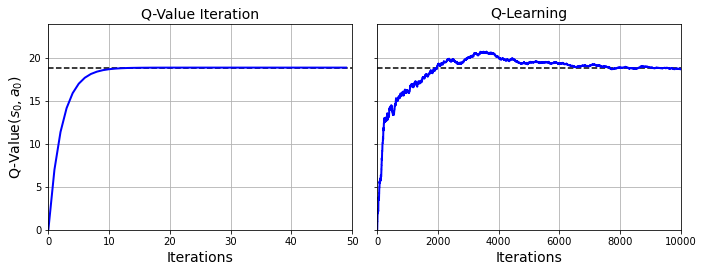

In [43]:
true_Q_value = history1[-1, 0, 0]
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel('Q-Value$(s_0, a_0)$', fontsize=14)
axes[0].set_title('Q-Value Iteration', fontsize=14)
axes[1].set_title('Q-Learning', fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], 'k--')
    ax.plot(np.arange(width), history[:, 0, 0], 'b-', linewidth=2)
    ax.set_xlabel('Iterations', fontsize=14)
    ax.axis([0, width, 0, 24])
    ax.grid(True)

plt.show()

The Q-learning algorithm is called an *off-policy* algorithm because the policy being trained is not necessarily the one used during training. e.g. in the code we just ran, the policy being executed (the exploration policy) was completely random, while the policy being trained was never used. After training, the optimal policy corresponds to systematically choosing the action with the highest Q-value. Conversely, the policy gradients algorithm is an *on-policy* algorithm: it explores the world using the policy being trained. It is somewhat surprising that Q-learning is capable of learning the optimal policy by just watching an agent act randomly.

### Exploration Policies
A better option is to use the $\varepsilon$-greedy policy: at each step it acts randomly with probability $\varepsilon$, or greedily with probability 1 – $\varepsilon$ (i.e., choosing the action with the highest Q-value). The advantage compared to a completely random policy is that it will spend more and more time exploring the interesting parts of the environment. It is quite common to start with a high value for $\varepsilon$ (e.g., 1.0) and then gradually reduce it (e.g., down to 0.05).

Alternatively, rather than relying only on chance for exploration, another approach is to encourage the exploration policy to try actions that it has not tried much before.

**Equation 18-6** Q-learning using an exploration function
$$
Q(s,a)\underset{\alpha}{\gets}
r+\gamma\cdot\underset{a^\prime}{\max}
\;f(Q(s^\prime,a^\prime),N(s^\prime,a^\prime))
$$
- $N(s^\prime,a^\prime)$: Counts the number of times the action $a^\prime$ was chosen in state $s^\prime$
- $f(Q,N)$: An *exploration function*, such as $f(Q,N)=Q+\kappa/(1+N)$, where $\kappa$ is a curiosity hyperparameter that measures how much the agent is attracted to the unknown.

### Approximate Q-Learning and Deep Q-Learning
The main problem with Q-learning is that it does not scale well to large (or even medium) MDPs with many states and actions. The solution is to find a function $Q_{\boldsymbol{\theta}}(s, a)$ that approximates the Q-value of any state-action pair ($s$, $a$) using a manageable number of parameters (given by the parameter vector $\boldsymbol{\theta}$). This is called *approximate Q-learning*. In 2013, DeepMind showed that estimating Q-values using deep neural networks can work very well, especially for complex problems, and it does not require any feature engineering. A DNN used to estimate Q-values is called a *deep Q-network* (DQN), and using a DQN for approximate Q-learning is called *deep Q-learning*.

To train the DQN we define target Q-value according to Bellman equation:

**Equation 18-7** Target Q-value
$$
y(s,a)=r+\gamma\cdot\underset{a^\prime}{\max}\;Q_{\boldsymbol{\theta}}(s^\prime,a^\prime)
$$

We can then use MSE or Huber loss.

## Implementing Deep Q-Learning
In theory, we need a neural net that takes a state-action pair as input, and outputs an approximate Q-value. However, in practice it’s much more efficient to use a neural net that takes only a state as input, and outputs one approximate Q-value for each possible action.

In [44]:
# Ensures reproducibility on the CPU
keras.utils.set_random_seed(42)

# == env.observation_space.shape
input_shape = [4]
# == env.action_space.n
n_outputs = 2

model = keras.Sequential(
    [
        keras.layers.Dense(32, activation='elu', input_shape=input_shape),
        keras.layers.Dense(32, activation='elu'),
        keras.layers.Dense(n_outputs),
    ]
)

To select an action using this DQN, we just pick the action with the largest predicted Q-value. However, to ensure that the agent explores the environment, we choose a random action with probability `epsilon`.

In [45]:
def epsilon_greedy_policy(state: np.ndarray, epsilon: float = 0) -> int:
    # Random action
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    # Optimal action according to the DQN
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()

Instead of training the DQN based only on the latest experiences, we will store all experiences in a *replay buffer* (or *replay memory*), and we will sample a random training batch from it at each training iteration. This helps reduce the correlations between the experiences in a training batch, which tremendously helps training. It will contain the agent’s experiences, in the form of tuples: `(obs, action, reward, next_obs, done)`. We can use the `deque` class for that:

In [46]:
from collections import deque

replay_buffer = deque(maxlen=2000)

**Tip**: A *deque* is a queue elements can be efficiently added to or removed from on both ends. Inserting and deleting items from the ends of the queue is very fast, but random access can be slow when the queue gets long. For a very large replay buffer, we should use a circular buffer instead, as random access time will be $O(1)$ instead of $O(N)$, or check out [DeepMind’s Reverb library](https://github.com/deepmind/reverb).

In [47]:
# A basic circular buffer implementation
from typing import Any


class ReplayBuffer:
    def __init__(self, max_size: int) -> None:
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj: Any) -> None:
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size: int) -> Any:
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]

And let’s create a function to sample experiences from the replay buffer. It 
will return 6 NumPy arrays: `[obs, actions, rewards, next_obs, dones, 
truncateds]`.

In [48]:
def sample_experiences(batch_size: int) -> tuple[np.ndarray, ...]:
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    # [states, actions, rewards, next_states, dones, truncateds]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]

Now we can create a function that will use the DQN to play one step, and record 
its experience in the replay buffer:

In [49]:
def play_one_step(
    env: gym.Env,
    state: np.ndarray,
    epsilon: float,
) -> tuple[np.ndarray, int, bool, bool, dict[str, Any]]:
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

Lastly, let’s create a function that will sample some experiences from the 
replay buffer and perform a training step:

In [50]:
# For reproducibility, and to generate the next figure
env.reset(seed=42)
keras.utils.set_random_seed(42)
rewards = []
best_score = 0

In [51]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error


def training_step(batch_size: int) -> None:
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    # Episode is not done or truncated
    runs = 1.0 - (dones | truncateds)
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

And now, let’s train the model!

In [52]:
for episode in range(600):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    # Displays debug info, stores data for the next figure, and keeps
    # track of the best model weights so far
    print(
        f'\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}',
        end='',
    )
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)

# Restores the best model weights
model.set_weights(best_weights)

Episode: 600, Steps: 200, eps: 0.010

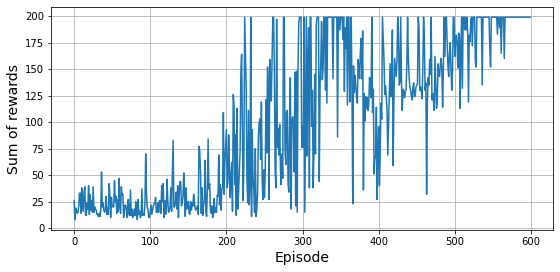

In [53]:
# This cell plots the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Sum of rewards', fontsize=14)
plt.grid(True)
plt.show()

In [54]:
# Shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)

Not bad at all! 😀

It looked like the algorithm had finally stabilized near the max reward, at around episode 320, its score again dropped down dramatically. This is called *catastrophic forgetting*, and it is one of the big problems facing virtually all RL algorithms: as the agent explores the environment, it updates its policy, but what it learns in one part of the environment may break what it learned earlier in other parts of the environment.

If we increase the size of the replay buffer, the algorithm will be less subject to this problem. Tuning the learning rate may also help. But the truth is, RL is hard: training is often unstable, and we may need to try many hyperparameter values and random seeds before we find a combination that works well. e.g., if we try changing the activation function from `'elu'` to `'relu'`, the performance will be much lower. A great [2018 post](https://homl.info/rlhard) by Alex Irpan nicely lays out RL’s biggest difficulties and limitations.

Why we didn’t plot the loss? It turns out that loss is a poor indicator of the model’s performance. The loss might go down, yet the agent might perform worse (e.g., this can happen when the agent gets stuck in one small region of the environment, and the DQN starts overfitting this region). Conversely, the loss could go up, yet the agent might perform better (e.g., if the DQN was underestimating the Q-values and it starts correctly increasing its predictions, the agent will likely perform better, getting more rewards, but the loss might increase because the DQN also sets the targets, which will be larger too). So, it’s preferable to plot the rewards.

## Deep Q-Learning Variants

### Fixed Q-Value Targets
In the basic deep Q-learning algorithm, the model is used both to make predictions and to set its own targets. This feedback loop can make the network unstable: it can diverge, oscillate, freeze, and so on. To solve this problem, in their 2013 paper the DeepMind researchers used two DQNs instead of one: the first is the *online model*, which learns at each step and is used to move the agent around, and the other is the *target model* used only to define the targets. The target model is just a clone of the online model.

Let’s create the online DQN:

In [55]:
# Creates the same DQN model as earlier
keras.utils.set_random_seed(42)

model = keras.Sequential(
    [
        keras.layers.Dense(32, activation='elu', input_shape=input_shape),
        keras.layers.Dense(32, activation='elu'),
        keras.layers.Dense(n_outputs),
    ]
)

Now create the target DQN:

In [56]:
# Clone the model’s architecture
target = keras.models.clone_model(model)
# Copy the weights
target.set_weights(model.get_weights())

Next, we use the same code as above except for the line marked with `# CHANGED`:

In [57]:
env.reset(seed=42)
keras.utils.set_random_seed(42)
rewards = []
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

# Resets the replay buffer
replay_buffer = deque(maxlen=2000)


def training_step(batch_size: int) -> None:
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    # CHANGED
    next_Q_values = target.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    # Episode is not done or truncated
    runs = 1.0 - (dones | truncateds)
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

Again, this is the same code as earlier, except for the lines marked with `# <= CHANGED`:

In [58]:
for episode in range(600):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    # Displays debug info, stores data for the next figure, and keeps
    # track of the best model weights so far
    print(
        f'\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}',
        end='',
    )
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        # CHANGED
        if episode % 50 == 0:
            # CHANGED
            target.set_weights(model.get_weights())

    # Alternatively, we can do soft updates at each step:
    # if episode > 50:
    #     training_step(batch_size)
    #     target_weights = target.get_weights()
    #     online_weights = model.get_weights()
    #     for index, online_weight in enumerate(online_weights):
    #         target_weights[index] = (
    #             0.99 * target_weights[index] + 0.01 * online_weight
    #         )
    #     target.set_weights(target_weights)

# Restores the best model weights
model.set_weights(best_weights)

Episode: 600, Steps: 200, eps: 0.010

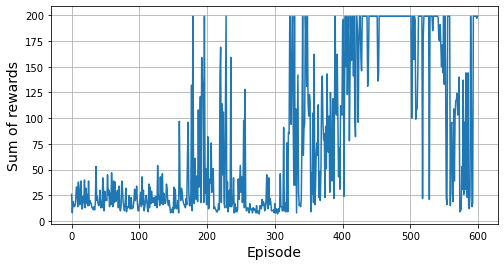

In [59]:
# This cell plots the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Sum of rewards', fontsize=14)
plt.grid(True)
plt.show()

In [60]:
# Shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)

### Double DQN
In a 2015 paper [“Deep Reinforcement Learning with Double Q-Learning”](https://homl.info/doubledqn), DeepMind researchers Hado van Hasselt et al., tweaked their DQN algorithm, increasing its performance and somewhat stabilizing training. They called this variant *double DQN*. The update was based on the observation that the target network is prone to overestimating Q-values. Indeed, suppose all actions are equally good: the Q-values estimated by the target model should be identical, but since they are approximations, some may be slightly greater than others, by pure chance. The target model will always select the largest Q-value, which will be slightly greater than the mean Q-value, most likely overestimating the true Q-value. To fix this, the researchers proposed using the online model instead of the target model when selecting the best actions for the next states, and using the target model only to estimate the Q-values for these best actions.

The code is exactly the same as for fixed Q-Value targets, except for the section marked as changed in the `training_step()` function:

In [61]:
keras.utils.set_random_seed(42)

model = keras.Sequential(
    [
        keras.layers.Dense(32, activation='elu', input_shape=input_shape),
        keras.layers.Dense(32, activation='elu'),
        keras.layers.Dense(n_outputs),
    ]
)

# Clone the model’s architecture
target = keras.models.clone_model(model)
# Copy the weights
target.set_weights(model.get_weights())

env.reset(seed=42)
rewards = []
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error


def training_step(batch_size: int) -> None:
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences

    # ------------------------- CHANGED SECTION ------------------------
    # ≠ target.predict()
    next_Q_values = model.predict(next_states, verbose=0)
    best_next_actions = next_Q_values.argmax(axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (
        target.predict(next_states, verbose=0) * next_mask
    ).sum(axis=1)
    # ------------------------------------------------------------------

    # Episode is not done or truncated
    runs = 1.0 - (dones | truncateds)
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))


replay_buffer = deque(maxlen=2000)

for episode in range(600):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(
        f'\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}',
        end='',
    )
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 600, Steps: 200, eps: 0.010

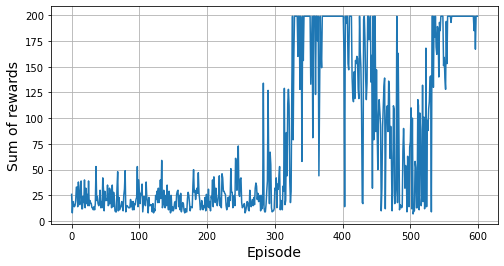

In [62]:
# This cell plots the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Sum of rewards', fontsize=14)
plt.grid(True)
plt.show()

In [63]:
# Shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)

### Prioritized Experience Replay
Instead of sampling experiences uniformly from the replay buffer, why not sample important experiences more frequently? This idea is called *importance sampling* (IS) or *prioritized experience replay* (PER), and it was introduced in a 2015 paper [](https://homl.info/prioreplay) by DeepMind researchers Tom Schaul et al.

Experiences are considered “important” if they are likely to lead to fast learning progress. One reasonable approach is to measure the magnitude of the TD error $\delta=r+\gamma\cdot V(s^\prime)-V(s)$. A large TD error indicates that a transition ($s$, $a$, $s^\prime$) is very surprising, and thus probably worth learning from (It could also just be that the rewards are noisy, in which case there are better methods for estimating an experience’s importance).  When an experience is recorded in the replay buffer, its priority is set to a very large value, to ensure that it gets sampled at least once. Once it is sampled (and every time it is sampled), the TD error $\delta$ is computed, and this experience’s priority is set to $p=|\delta|$ (plus a small constant to ensure that every experience has a nonzero probability of being sampled). The probability $P$ of sampling an experience with priority $p$ is proportional to $p^\zeta$, where $\zeta$ is a hyperparameter that controls how greedy we want importance sampling to be: when $\zeta=0$, we just get uniform sampling, and when $\zeta=1$, we get full-blown importance sampling. In the paper, the authors used $\zeta=0.6$, but the optimal value will depend on the task.

Since the samples will be biased toward important experiences, we must compensate for this bias during training by downweighting the experiences according to their importance, or else the model will just overfit the important experiences. To do this, we define each experience’s training weight as $w=(nP)^{–\beta}$, where $n$ is the number of experiences in the replay buffer, and $\beta$ is a hyperparameter that controls how much we want to compensate for the importance sampling bias (0 means not at all, while 1 means entirely). In the paper, the authors used $\beta=0.4$ at the beginning of training and linearly increased it to $\beta=1$ by the end of training. Again, the optimal value will depend on the task, but if we increase one, we will usually want to increase the other as well.

### Dueling DQN
The *dueling DQN* algorithm (DDQN) was introduced in yet another 2015 paper [“Dueling Network Architectures for Deep Reinforcement Learning”](https://homl.info/ddqn) by DeepMind researchers Ziyu Wang et al. To understand how it works, we must first note that the Q-value of a state-action pair ($s$, $a$) can be expressed as $Q(s,a)=V(s)+A(s, a)$, where $V(s)$ is the value of state $s$ and $A(s,a)$ is the *advantage* of taking the action $a$ in state $s$, compared to all other possible actions in that state. Moreover, the value of a state is equal to the Q-value of the best action $a^*$ for that state (since we assume the optimal policy will pick the best action), so $V(s)=Q(s,a^*)$, which implies that $A(s, a^*)=0$. In a dueling DQN, the model estimates both the value of the state and the advantage of each possible action. Since the best action should have an advantage of 0, the model subtracts the maximum predicted advantage from all predicted advantages.

In [64]:
# Ensures reproducibility on the CPU
keras.utils.set_random_seed(42)

input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation='elu')(input_states)
hidden2 = keras.layers.Dense(32, activation='elu')(hidden1)
state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - tf.reduce_max(
    raw_advantages, axis=1, keepdims=True
)
Q_values = state_values + advantages
model = keras.Model(inputs=[input_states], outputs=[Q_values])

The rest is the same code as earlier:

In [65]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Nadam(learning_rate=5e-3)
loss_fn = keras.losses.mean_squared_error

# Clone the model’s architecture
target = keras.models.clone_model(model)
# Copy the weights
target.set_weights(model.get_weights())

env.reset(seed=42)
replay_buffer = deque(maxlen=2000)
rewards = []
best_score = 0

for episode in range(600):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(
        f'\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}',
        end='',
    )
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 600, Steps: 137, eps: 0.010

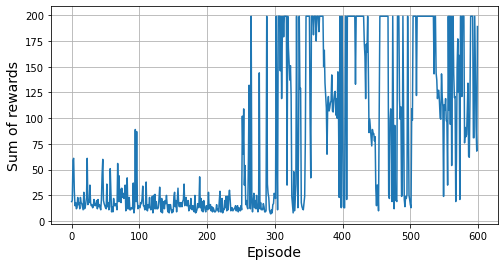

In [66]:
# This cell plots the learning curve
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Sum of rewards', fontsize=14)
plt.grid(True)
plt.show()

In [67]:
# Shows an animation of the trained DQN playing one episode
show_one_episode(epsilon_greedy_policy)

This looks like a pretty robust agent!

In [68]:
env.close()

Many RL techniques can be combined, as DeepMind demonstrated in a 2017 paper [“Rainbow: Combining Improvements in Deep Reinforcement Learning”](https://homl.info/rainbow) by Matteo Hessel et al.: the authors combined six different techniques into an agent called Rainbow, which largely outperformed the state of the art.

## Overview of Some Popular RL Algorithms
<style>ul {list-style-type: none;}</style>

*AlphaGo*
- AlphaGo proposed a in 2017 paper [“Mastering the Game of Go with Deep Neural Networks and Tree Search”](https://homl.info/alphago) by David Silver et al. uses a variant of Monte Carlo tree search (MCTS) based on deep neural networks to beat human champions at the game of Go. MCTS was invented in 1949 by Nicholas Metropolis and Stanislaw Ulam. It selects the best move after running many simulations, repeatedly exploring the search tree starting from the current position, and spending more time on the most promising branches. When it reaches a node that it hasn’t visited before, it plays randomly until the game ends, and updates its estimates for each visited node (excluding the random moves), increasing or decreasing each estimate depending on the final outcome. AlphaGo is based on the same principle, but it uses a policy network to select moves, rather than playing randomly. This policy net is trained using policy gradients. The original algorithm involved three more neural networks, and was more complicated, but it was simplified in the AlphaGo Zero paper [“Mastering the Game of Go Without Human Knowledge”](https://homl.info/alphagozero), which uses a single neural network to both select moves and evaluate game states. The AlphaZero paper [“Mastering Chess and Shogi by Self-Play with a General Reinforcement Learning Algorithm”](https://homl.info/alphazero) generalized this algorithm, making it capable of tackling not only the game of Go, but also chess and shogi (Japanese chess). Lastly, the MuZero paper [“Mastering Atari, Go, Chess and Shogi by Planning with a Learned Model”](https://homl.info/muzero) by Julian Schrittwieser et al., continued to improve upon this algorithm, outperforming the previous iterations even though the agent starts out without even knowing the rules of the game!

*Actor-critic algorithms*
- Actor-critics are a family of RL algorithms that combine policy gradients with deep Q-networks. An actor-critic agent contains two neural networks: a policy net and a DQN. The DQN is trained normally, by learning from the agent’s experiences. The policy net learns differently (and much faster) than in regular PG: instead of estimating the value of each action by going through multiple episodes, then summing the future discounted rewards for each action, and finally normalizing them, the agent (actor) relies on the action values estimated by the DQN (critic). It’s a bit like an athlete (the agent) learning with the help of a coach (the DQN).

*Asynchronous advantage actor-critic (A3C)*
- This is an important actor-critic variant introduced by DeepMind researchers in a 2016 paper [“Asynchronous Methods for Deep Reinforcement Learning”](https://homl.info/a3c) by Volodymyr Mnih et al. where multiple agents learn in parallel, exploring different copies of the environment. At regular intervals, but asynchronously (hence the name), each agent pushes some weight updates to a master network, then it pulls the latest weights from that network. Each agent thus contributes to improving the master network and benefits from what the other agents have learned. Moreover, instead of estimating the Q-values, the DQN estimates the advantage of each action (hence the second A in the name), which stabilizes training.

*Advantage actor-critic (A2C)*
- [A2C](https://homl.info/a2c) is a variant of the A3C algorithm that removes the asynchronicity. All model updates are synchronous, so gradient updates are performed over larger batches, which allows the model to better utilize the power of the GPU.

*Soft actor-critic (SAC)*
- SAC is an actor-critic variant proposed in a 2018 paper [“Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor”](https://homl.info/sac) by Tuomas Haarnoja and other UC Berkeley researchers. It learns not only rewards, but also to maximize the entropy of its actions. In other words, it tries to be as unpredictable as possible while still getting as many rewards as possible. This encourages the agent to explore the environment, which speeds up training, and makes it less likely to repeatedly execute the same action when the DQN produces imperfect estimates. This algorithm has demonstrated an amazing sample efficiency (contrary to all the previous algorithms, which learn very slowly).

*Proximal policy optimization (PPO)*
- This algorithm by John Schulman and other OpenAI researchers proposed in a 2017 paper [“Proximal Policy Optimization Algorithms”](https://homl.info/ppo) is based on A2C, but it clips the loss function to avoid excessively large weight updates (which often lead to training instabilities). PPO is a simplification of the previous trust region policy optimization (TRPO) algorithm proposed in a 2015 paper [“Trust Region Policy Optimization”](https://homl.info/trpo), also by OpenAI. OpenAI made the news in April 2019 with its AI called OpenAI Five, based on the PPO algorithm, which defeated the world champions at the multiplayer game Dota 2.

*Curiosity-based exploration*
- A recurring problem in RL is the sparsity of the rewards, which makes learning very slow and inefficient. Deepak Pathak and other UC Berkeley researchers have proposed an exciting way to tackle this issue in a 2017 paper [“Curiosity-Driven Exploration by Self-Supervised Prediction”](https://homl.info/curiosity): why not ignore the rewards, and just make the agent extremely curious to explore the environment? The rewards thus become intrinsic to the agent, rather than coming from the environment. Similarly, stimulating curiosity in a child is more likely to give good results than purely rewarding the child for getting good grades. How does this work? The agent continuously tries to predict the outcome of its actions, and it seeks situations where the outcome does not match its predictions. In other words, it wants to be surprised. If the outcome is predictable (boring), it goes elsewhere. However, if the outcome is unpredictable but the agent notices that it has no control over it, it also gets bored after a while. With only curiosity, the authors succeeded in training an agent at many video games: even though the agent gets no penalty for losing, the game starts over, which is boring so it learns to avoid it.

*Open-ended learning (OEL)*
- The objective of OEL is to train agents capable of endlessly learning new and interesting tasks, typically generated procedurally. We’re not there yet, but there has been some amazing progress over the last few years. e.g. a 2019 paper [“Paired Open-Ended Trailblazer (POET): Endlessly Generating Increasingly Complex and Diverse Learning Environments and Their Solutions”](https://homl.info/poet) by Rui Wang et al. a team of researchers from Uber AI introduced the POET algorithm, which generates multiple simulated 2D environments with bumps and holes and trains one agent per environment: the agent’s goal is to walk as fast as possible while avoiding the obstacles. The algorithm starts out with simple environments, but they gradually get harder over time: this is called *curriculum learning*. Moreover, although each agent is only trained within one environment, it must regularly compete against other agents, across all environments. In each environment, the winner is copied over and it replaces the agent that was there before. This way, knowledge is regularly transferred across environments, and the most adaptable agents are selected. In the end, the agents are much better walkers than agents trained on a single task, and they can tackle much harder environments. Of course, this principle can be applied to other environments and tasks as well. If we’re interested in OEL, make sure to check out the Enhanced POET paper [“Enhanced POET: Open-Ended Reinforcement Learning Through Unbounded Invention of Learning Challenges and Their Solutions”](https://homl.info/epoet), as well as DeepMind’s 2021 paper[“Open-Ended Learning Leads to Generally Capable Agents”](https://homl.info/oel2021) on this topic.

## Exercises

### 1. to 8.
1. How would we define reinforcement learning? How is it different from regular supervised or unsupervised learning?
> Reinforcement learning is an area of machine learning aimed at creating agents capable of taking actions in an environment in a way that maximizes rewards over time. There are many differences between RL and regular supervised and unsupervised learning. Here are a few:
> - In supervised and unsupervised learning, the goal is generally to find patterns in the data and use them to make predictions. In reinforcement learning, the goal is to find a good policy.
> - Unlike in supervised learning, the agent is not explicitly given the “right” answer. It must learn by trial and error.
> - Unlike in unsupervised learning, there is a form of supervision, through rewards. We do not tell the agent how to perform the task, but we do tell it when it is making progress or when it is failing.
> - A reinforcement learning agent needs to find the right balance between exploring the environment, looking for new ways of getting rewards, and exploiting sources of rewards that it already knows. In contrast, supervised and unsupervised learning systems generally don’t need to worry about exploration; they just feed on the training data they are given.
> - In supervised and unsupervised learning, training instances are typically independent (in fact, they are generally shuffled). In reinforcement learning, consecutive observations are generally *not* independent. An agent may remain in the same region of the environment for a while before it moves on, so consecutive observations will be very correlated. In some cases a replay buffer (memory) is used to ensure that the training algorithm gets fairly independent observations.
2. Can we think of three possible applications of RL that were not mentioned in this chapter? For each of them, what is the environment? What is the agent? What are some possible actions? What are the rewards?
> - Music personalization: The environment is a user’s personalized web radio. The agent is the software deciding what song to play next for that user. Its possible actions are to play any song in the catalog (it must try to choose a song the user will enjoy) or to play an advertisement (it must try to choose an ad that the user will be interested in). It gets a small reward every time the user listens to a song, a larger reward every time the user listens to an ad, a negative reward when the user skips a song or an ad, and a very negative reward if the user leaves.
> - Marketing: The environment is our company’s marketing department. The agent is the software that defines which customers a mailing campaign should be sent to, given their profile and purchase history (for each customer it has two possible actions: send or don’t send). It gets a negative reward for the cost of the mailing campaign, and a positive reward for estimated revenue generated from this campaign.
> - Product delivery: Let the agent control a fleet of delivery trucks, deciding what they should pick up at the depots, where they should go, what they should drop off, and so on. It will get positive rewards for each product delivered on time, and negative rewards for late deliveries.
3. What is the discount factor? Can the optimal policy change if we modify the discount factor?
> When estimating the value of an action, reinforcement learning algorithms typically sum all the rewards that this action led to, giving more weight to immediate rewards and less weight to later rewards (considering that an action has more influence on the near future than on the distant future). To model this, a discount factor is typically applied at each time step. e.g. with a discount factor of 0.9, a reward of 100 that is received two time steps later is counted as only $0.9^2\times 100=81$ when we are estimating the value of the action. we can think of the discount factor as a measure of how much the future is valued relative to the present: if it is very close to 1, then the future is valued almost as much as the present; if it is close to 0, then only immediate rewards matter. Of course, this impacts the optimal policy tremendously: if we value the future, we may be willing to put up with a lot of immediate pain for the prospect of eventual rewards, while if we don’t value the future, we will just grab any immediate reward we can find, never investing in the future.
4. How do we measure the performance of a reinforcement learning agent?
> We can simply sum up the rewards it gets. In a simulated environment, we can run many episodes and look at the total rewards it gets on average (and possibly look at the min, max, standard deviation, and so on).
5. What is the credit assignment problem? When does it occur? How can we alleviate it?
> The credit assignment problem is the fact that when a reinforcement learning agent receives a reward, it has no direct way of knowing which of its previous actions contributed to this reward. It typically occurs when there is a large delay between an action and the resulting reward (e.g., during a game of Atari’s *Pong*, there may be a few dozen time steps between the moment the agent hits the ball and the moment it wins the point). One way to alleviate it is to provide the agent with shorter-term rewards, when possible. This usually requires prior knowledge about the task. e.g. if we want to build an agent that will learn to play chess, instead of giving it a reward only when it wins the game, we could give it a reward every time it captures one of the opponent’s pieces.
6. What is the point of using a replay buffer?
> An agent can often remain in the same region of its environment for a while, so all of its experiences will be very similar for that period of time. This can introduce some bias in the learning algorithm. It may tune its policy for this region of the environment, but it will not perform well as soon as it moves out of this region. To solve this problem, we can use a replay buffer; instead of using only the most immediate experiences for learning, the agent will learn based on a buffer of its past experiences, recent and not so recent (perhaps this is why we dream at night: to replay our experiences of the day and better learn from them?).
7. What is an off-policy RL algorithm?
> An off-policy RL algorithm learns the value of the optimal policy (i.e., the sum of discounted rewards that can be expected for each state if the agent acts optimally) while the agent follows a different policy. Q-Learning is a good example of such an algorithm. In contrast, an on-policy algorithm learns the value of the policy that the agent actually executes, including both exploration and exploitation.
8. Use policy gradients to solve ~~OpenAI Gym~~ Gymnasium’s LunarLander-v2 environment.
> Let’s start by creating a LunarLander-v2 environment:

In [69]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')

> The inputs are 8-dimensional:

In [70]:
env.observation_space

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)

In [71]:
obs, info = env.reset(seed=42)
obs

array([ 0.00229702,  1.4181306 ,  0.2326471 ,  0.3204666 , -0.00265488,
       -0.05269805,  0.        ,  0.        ], dtype=float32)

> From the [source code](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/box2d/lunar_lander.py), we can see that these each 8D observation `[x, y, h, v, a, w, l, r]` correspond to:
> - `x`, `y`: The coordinates of the spaceship. It starts at a random location near (0, 1.4) and must land near the target at (0, 0).
> - `h`, `v`: The horizontal and vertical speed of the spaceship. It starts with a small random speed.
> - `a`, `w`: The spaceship’s angle and angular velocity.
> - `l`, `r`: Whether the left or right leg touches the ground (1.0) or not (0.0).
>
> The action space is discrete, with 4 possible actions:

In [72]:
env.action_space

Discrete(4)

> Looking at the [LunarLander-v2's description](https://gymnasium.farama.org/environments/box2d/lunar_lander/), these actions are:
> - 0: Do nothing
> - 1: Fire left orientation engine
> - 2: Fire main engine
> - 3: Fire right orientation engine
>
> For each step, the reward:
> - Is increased/decreased the closer/further the lander is to the landing pad.
> - Is increased/decreased the slower/faster the lander is moving.
> - Is decreased the more the lander is tilted (angle not horizontal).
> - Is increased by 10 points for each leg that is in contact with the ground.
> - Is decreased by 0.03 points each frame a side engine is firing.
> - Is decreased by 0.3 points each frame the main engine is firing.
>
> The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.
>
> An episode is considered a solution if it scores at least 200 points.
>
> The episode finishes if:
> 1. The lander crashes (the lander body gets in contact with the moon);
> 2. The lander gets outside of the viewport (`x` is greater than 1);
> 3. the lander is not awake. From the [Box2D docs](https://box2d.org/documentation/md__d_1__git_hub_box2d_docs_dynamics.html#autotoc_md61), a body which is not awake is a body which doesn’t move and doesn’t collide with any other body.
>
> Let’s create a simple policy network with 4 output neurons (one per possible action):

In [73]:
keras.utils.set_random_seed(42)

n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

model = keras.Sequential(
    [
        keras.layers.Dense(32, activation='relu', input_shape=[n_inputs]),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(n_outputs, activation='softmax'),
    ]
)

> Next, let’s reuse the `play_one_step()` and `play_multiple_episodes()` functions we defined for the CartPole-v1 Policy Gradient code above, but we’ll just tweak the `play_one_step()` function to account for the fact that the model is now a multiclass classification model rather than a binary classification model. We’ll also tweak the `play_multiple_episodes()` function to call our tweaked `play_one_step()` function rather than the original one.

In [74]:
def lander_play_one_step(
    env: gym.Env,
    obs: np.ndarray,
    model: keras.Model,
    loss_fn: keras.losses.Loss,
) -> tuple[np.ndarray, float, bool, bool, tf.Tensor]:
    with tf.GradientTape() as tape:
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        loss = tf.reduce_mean(loss_fn(action, probas))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info, truncated = env.step(action[0, 0].numpy())
    return obs, reward, done, truncated, grads


def lander_play_multiple_episodes(
    env: gym.Env,
    n_episodes: int,
    n_max_steps: int,
    model: keras.Model,
    loss_fn: keras.losses.Loss,
) -> tuple[list[list[float]], list[list[tf.Tensor]]]:
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = lander_play_one_step(
                env, obs, model, loss_fn
            )
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

> We’ll keep exactly the same `discount_rewards()` and `discount_and_normalize_rewards()` functions as earlier:

In [75]:
def discount_rewards(
    rewards: list[float], discount_factor: float
) -> np.ndarray:
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted


def discount_and_normalize_rewards(
    all_rewards: list[list[float]], discount_factor: float
) -> list[np.ndarray]:
    all_discounted_rewards = [
        discount_rewards(rewards, discount_factor) for rewards in all_rewards
    ]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [
        (discounted_rewards - reward_mean) / reward_std
        for discounted_rewards in all_discounted_rewards
    ]

> Now let’s define some hyperparameters:

In [76]:
n_iterations = 200
n_episodes_per_update = 16
n_max_steps = 1000
discount_factor = 0.99

> Again, since the model is a multiclass classification model, we must use the categorical cross-entropy rather than the binary cross-entropy. Moreover, since the `lander_play_one_step()` function sets the targets as class indices rather than class probabilities, we must use the `sparse_categorical_crossentropy()` loss function:

In [77]:
optimizer = keras.optimizers.Nadam(learning_rate=0.005)
loss_fn = keras.losses.sparse_categorical_crossentropy

> We’re ready to train the model. Let’s go!

In [78]:
env.reset(seed=42)

mean_rewards = []

for iteration in range(n_iterations):
    all_rewards, all_grads = lander_play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn
    )
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    print(
        f'\rIteration: {iteration + 1}/{n_iterations},'
        f' mean reward: {mean_reward:.1f}  ',
        end='',
    )
    mean_rewards.append(mean_reward)
    all_final_rewards = discount_and_normalize_rewards(
        all_rewards, discount_factor
    )
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [
                final_reward * all_grads[episode_index][step][var_index]
                for episode_index, final_rewards in enumerate(
                    all_final_rewards
                )
                for step, final_reward in enumerate(final_rewards)
            ],
            axis=0,
        )
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 200/200, mean reward: 167.1  

> Let’s look at the learning curve:

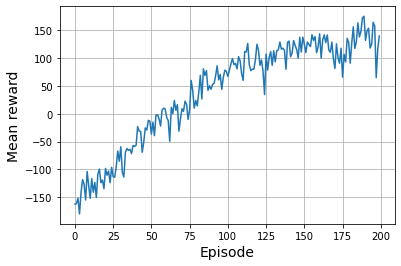

In [79]:
plt.plot(mean_rewards)
plt.xlabel('Episode')
plt.ylabel('Mean reward')
plt.grid()
plt.show()

> Now let’s look at the result!

In [80]:
def lander_render_policy_net(
    model: keras.Model, n_max_steps: int = 500, seed: int = 42
) -> list[np.ndarray]:
    frames = []
    env = gym.make('LunarLander-v2', render_mode='rgb_array')
    keras.utils.set_random_seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        obs, reward, done, truncated, info = env.step(action[0, 0].numpy())
        if done or truncated:
            break
    env.close()
    return frames

In [81]:
frames = lander_render_policy_net(model, seed=42)
plot_animation(frames)

> That’s pretty good. we can try training it for longer and/or tweaking the hyperparameters to see if we can get it to go over 200.

### 9. to 10.
9. Use a double dueling DQN to train an agent that can achieve a superhuman level at the famous Atari *Breakout* game (`'ALE/Breakout-v5'`). The observations are images. To simplify the task, we should convert them to grayscale (i.e., average over the channels axis), crop them and downsample them, so they’re just large enough to play, but not much more. An individual image does not tell us which way the ball and the paddles are going, so we should merge two or three consecutive images to form each state. Lastly, the DQN should be composed mostly of convolutional layers.
> TODO
>
> Check out the [state-of-the-art for Atari games on paperswithcode.com](https://paperswithcode.com/task/atari-games).
10. If we have about $100 to spare, we can purchase a Raspberry Pi 3 plus some cheap robotics components, install TensorFlow on the Pi, and go wild! e.g. check out this [fun post](https://homl.info/2) by Lukas Biewald, or take a look at GoPiGo or BrickPi. Start with simple goals, like making the robot turn around to find the brightest angle (if it has a light sensor) or the closest object (if it has a sonar sensor), and move in that direction. Then we can start using deep learning: e.g. if the robot has a camera, we can try to implement an object detection algorithm so it detects people and moves toward them. We can also try to use RL to make the agent learn on its own how to use the motors to achieve that goal. Have fun!
> It’s our turn now: go crazy, be creative, but most of all, be patient and move forward step by step, we can do it!